In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
import anndata as ad
#sys.path.append('/home/exx/git/Tangram/')  # uncomment for local import
#import telegraph as tg
import pyreadr

%load_ext autoreload
%autoreload 2
%matplotlib inline

#tg.__version__

/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def jaccard_index(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:  # handle the case where both lists are empty
        return 1.0
    return len(intersection) / len(union)

In [4]:
def pp_adata(ad_sc):
    """ Preprocessing function for adata objects

    """

    # remove mitochondiral and ribosomal genes
    is_mt = ad_sc.var_names.str.startswith("MT-")
    is_rp = ad_sc.var_names.str.startswith(("RPS", "RPL","RP-","RP"))
    keep_genes = (~is_mt) & (~is_rp)
    ad_sc = ad_sc[:,keep_genes].copy()

    # remove cells with low counts
    sc.pp.filter_cells(ad_sc,min_counts=300)
    # remove lowly expressed genes
    sc.pp.filter_genes(ad_sc,min_counts=10)

    # get hvg genes
    ad_sc.layers['raw'] = ad_sc.X.copy()
    sc.pp.normalize_total(ad_sc,1e4)
    sc.pp.log1p(ad_sc)
    sc.pp.highly_variable_genes(ad_sc,n_top_genes=5000)
    ad_sc.layers['norm'] = ad_sc.X.copy()
    ad_sc.X = ad_sc.layers['raw'].copy()
    
    return ad_sc

In [5]:
import re
import altair as alt

In [6]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr


In [7]:
folder_ID = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_eval/real/fetal_lung/cci/celltype_raw/B_development/'

In [8]:
ad_sc_all = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/lung/single_cell/'+
                     '220715Annotated_Fetal_lung_immune_filtered_soupxcite_cxg.h5ad')

In [23]:
B_split = ['HSC/MPP', 'LMPP/ELP', 'Pre-pro-B',  'Pro-B', 'Late pro-B', 'Pro-B/Pre-B transition','Large pre-B', 'κ small pre-B', 'λ small pre-B', 
          'Late pre-B','Immature B', 'CD5+ Mature B', 'CD5- Mature B'] # 

B_marker = ['CD34', 'EBF1', 'SPINK2','VPREB1', 'DNTT', 'NEIL1', 'RAG1', 'MS4A1', 'IL7R', 'MKI67','SPIB', 'IGKC', 'IGLC2', 'IGLC3',
            'IGLL1','IGHD','IGHM','VPREB3', 'BEST3', 'CD5','CD27', 'SPN', 'CCR10', 'CCL22', 'PRDM1']

In [24]:
B_fraction_df = pd.read_csv('/gstore/data/resbioai/tangram2_data/lung/B_cell_normalize/B_marker_fraction.csv', index_col = 0)
B_expression_df = pd.read_csv('/gstore/data/resbioai/tangram2_data/lung/B_cell_normalize/B_marker_expression.csv', index_col = 0)

In [25]:
file_list = os.listdir(folder_ID)
celltype_list = []
for i in file_list:
    celltype_list.append(i.split('.')[0])

In [26]:
pearson_corr = pd.DataFrame(index = celltype_list, columns = B_fraction_df.columns)

In [27]:
spearman_corr = pd.DataFrame(index = celltype_list, columns = B_fraction_df.columns)
for celltype in celltype_list:
    result = pd.read_csv(folder_ID + celltype + '.csv', index_col=0)
    for gene in spearman_corr.columns:
        res = spearmanr(result.loc[B_split, gene], B_expression_df.loc[B_split, gene])
        spearman_corr.loc[celltype, gene] = res.statistic

In [28]:
## reorder row based on median values
spearman_corr['median'] = spearman_corr.median(axis=1)
spearman_corr.sort_values(by='median', ascending=False, inplace=True)
spearman_corr.drop('median', axis=1, inplace=True)

<AxesSubplot: >

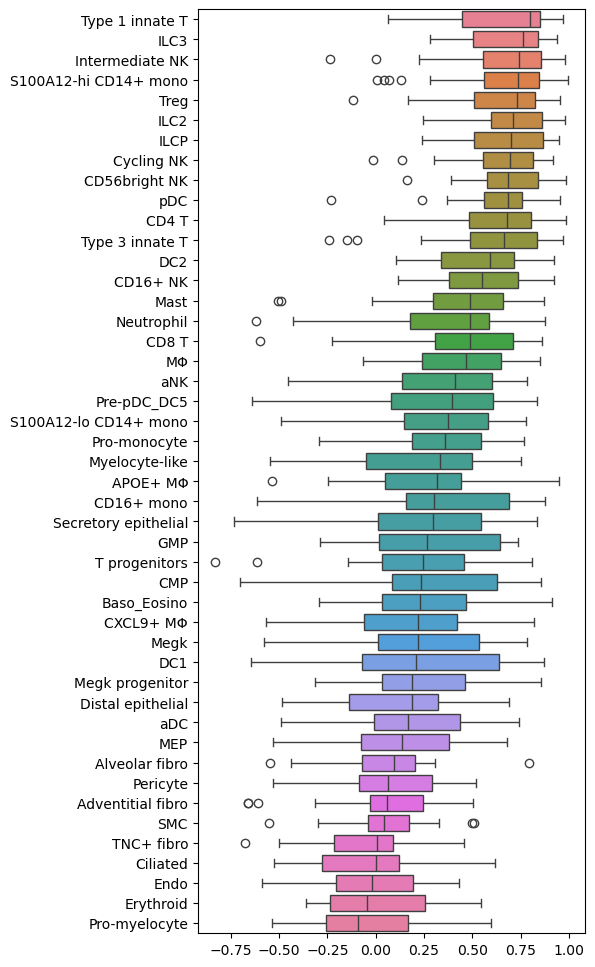

In [29]:
plt.figure(figsize=(5,12))
sns.boxplot(data=spearman_corr.T, orient="h",)

In [16]:
B_fraction_df

,CD34,EBF1,SPINK2,VPREB1,DNTT,NEIL1,RAG1,MS4A1,IL7R,MKI67,...,IGHD,IGHM,VPREB3,BEST3,CD5,CD27,SPN,CCR10,CCL22,PRDM1
HSC/MPP,0.974138,0.008621,0.931034,0.155172,0.000000,0.043103,0.008621,0.025862,0.077586,0.086207,...,0.112069,0.241379,0.008621,0.000000,0.000000,0.000000,0.793103,0.000000,0.000000,0.034483
LMPP/ELP,0.190769,0.110769,0.526154,0.206154,0.000000,0.033846,0.012308,0.326154,0.393846,0.221538,...,0.129231,0.353846,0.095385,0.006154,0.012308,0.024615,0.553846,0.015385,0.012308,0.076923
Pre-pro-B,0.203187,0.689243,0.243028,0.900398,0.019920,0.147410,0.402390,0.621514,0.788845,0.390438,...,0.450199,0.864542,0.689243,0.007968,0.019920,0.039841,0.689243,0.007968,0.003984,0.055777
Pro-B,0.226737,0.694626,0.043250,0.935780,0.559633,0.174312,0.636959,0.365662,0.674967,0.771953,...,0.463958,0.861075,0.950197,0.140236,0.011796,0.094364,0.338139,0.002621,0.002621,0.023591
Late pro-B,0.328767,0.538356,0.001370,0.971233,0.846575,0.436986,0.783562,0.068493,0.379452,0.060274,...,0.157534,0.621918,0.956164,0.165753,0.000000,0.278082,0.301370,0.002740,0.000000,0.010959
Pro-B/Pre-B transition,0.005731,0.409742,0.005731,0.878223,0.080229,0.512894,0.510029,0.330946,0.362464,0.038682,...,0.237822,0.868195,0.964183,0.247851,0.007163,0.073066,0.169054,0.001433,0.001433,0.014327
Large pre-B,0.033465,0.629921,0.033465,0.933071,0.072178,0.249344,0.175197,0.618766,0.692913,0.826115,...,0.353018,0.954724,0.971129,0.325459,0.040682,0.119423,0.448163,0.003937,0.003937,0.041995
κ small pre-B,0.005739,0.420373,0.000000,0.905308,0.021521,0.552367,0.456241,0.083214,0.285509,0.055954,...,0.167862,0.971306,0.975610,0.453372,0.002869,0.012912,0.175036,0.001435,0.000000,0.007174
λ small pre-B,0.003929,0.330059,0.001965,0.740668,0.007859,0.736739,0.683694,0.025540,0.174853,0.007859,...,0.121807,0.939096,0.958743,0.457760,0.000000,0.003929,0.143418,0.000000,0.000000,0.000000
Late pre-B,0.003021,0.285498,0.000000,0.521148,0.001511,0.574018,0.158610,0.429003,0.212991,0.012085,...,0.182779,0.950151,0.944109,0.238671,0.004532,0.004532,0.181269,0.000000,0.000000,0.003021


In [30]:
B_expression_df

,CD34,EBF1,SPINK2,VPREB1,DNTT,NEIL1,RAG1,MS4A1,IL7R,MKI67,...,IGHD,IGHM,VPREB3,BEST3,CD5,CD27,SPN,CCR10,CCL22,PRDM1
HSC/MPP,1.686115,0.016812,1.688354,0.187766,0.000000,0.040361,0.006789,0.042174,0.110061,0.121804,...,0.129494,0.378580,0.009276,0.000000,0.000000,0.000000,1.117877,0.000000,0.000000,0.032828
LMPP/ELP,0.274490,0.135427,0.800460,0.326650,0.000000,0.043654,0.013253,0.518151,0.605488,0.277263,...,0.157553,0.614843,0.147604,0.005786,0.011874,0.028181,0.658870,0.013005,0.015240,0.080485
Pre-pro-B,0.221077,0.855368,0.271175,1.603295,0.026230,0.176047,0.494535,0.974674,1.251434,0.530997,...,0.469471,1.563408,1.236990,0.006750,0.017208,0.047034,0.815276,0.005496,0.003299,0.054910
Pro-B,0.324839,1.104847,0.053240,1.999711,1.100822,0.249964,1.025690,0.618119,1.139830,1.505597,...,0.682680,1.753318,2.121096,0.220010,0.011862,0.116431,0.447900,0.001953,0.003268,0.032473
Late pro-B,0.667140,1.083413,0.001643,2.561736,2.074550,0.909745,1.792321,0.135620,0.753980,0.107166,...,0.291004,1.343919,2.483983,0.329507,0.000000,0.548656,0.571368,0.006175,0.000000,0.018964
Pro-B/Pre-B transition,0.010916,0.786927,0.007056,2.189923,0.161246,1.079751,1.121621,0.734264,0.721585,0.069101,...,0.444357,2.147194,2.515307,0.515142,0.011356,0.136639,0.306562,0.002791,0.003235,0.022190
Large pre-B,0.028402,0.787746,0.025119,1.863866,0.087920,0.284261,0.225003,1.029081,1.014524,1.433171,...,0.404590,1.863612,1.987155,0.440432,0.038461,0.112664,0.482453,0.003662,0.005447,0.036746
κ small pre-B,0.008936,0.805810,0.000000,2.198886,0.039388,1.148198,0.933731,0.155266,0.553655,0.106338,...,0.314908,2.340114,2.431041,0.896638,0.005060,0.022698,0.324981,0.003204,0.000000,0.011610
λ small pre-B,0.008333,0.683971,0.005220,1.810530,0.015946,1.673354,1.547523,0.048612,0.370489,0.016572,...,0.251118,2.359620,2.443224,0.996840,0.000000,0.007267,0.300465,0.000000,0.000000,0.000000
Late pre-B,0.005755,0.582331,0.000000,1.225324,0.002552,1.276439,0.345000,0.993860,0.440702,0.025458,...,0.366872,2.456844,2.453353,0.500850,0.008369,0.009743,0.366169,0.000000,0.000000,0.006600
